## You recently graduated from NTU and started to work for an internationally well-known engineering consultancy. Your company recently won a project to support Accra city (in Ghena, Africa) in flood risk analysis.  

## To better understand the flood risk of a given place, it is essential to perform extreme statistical analysis, or known as return period analysis. 

## Because you mentioned in your CV that you took the 'Computational Statistics' course in NTU, your line manager decides to assign this task to you. More specifically, you are going to perform the following analyses with the attached '_AnnualMaxima_1D_Kiamo-Tema.csv_' data file, where 1-day rainfall annual maxima of two main towns in Accra (Kiamo and Tema) from 1960 to 2022 are available. 

### 0. import essential modules

In [1]:
from scipy.optimize import minimize
import scipy.stats as stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 1. (30%) Read CSV data file and perform the following tasks:

#### 1.1 (15%) Retrieve 1-day annual maxima data for _Kiamo_ and _Tema_, and print out the number of years with valid* data for each location.
#### 1.2 (15%) Calculate the pearson correlation and the 95% confidence interval of the correlation estimation of 1-day rainfall  annual maxima between Kiamo and Tema.

#### * Note that _invalid_ data values are represented by -9999, and you should filter these values out. 

#### Note for printing: please follow the following format:

Number of valid years in Kiamo: XXXX</br>
Number of valid years in Tema: XXXX</br>
Correlation coefficent of 1-day rainfall AMs is: XXXX (3-decimal places)</br>
The confidence interval for correlation is: [lower, upper] (3-decimal places)

In [2]:
path = './Data/AnnualMaxima_1D_Kiamo-Tema.csv'
df = pd.read_csv(path)

Kiamo_data = df["Kiamo"]
Tema_data = df["Tema"]
Kiamo_invalid_num = (Kiamo_data == -9999).sum()
Tema_invalid_num = (Tema_data == -9999).sum()
print(f"Number of valid years in Kiamo: {Kiamo_data.count()-Kiamo_invalid_num}")
print(f"Number of valid years in Tema: {Tema_data.count()-Tema_invalid_num}")

Kiamo_data = Kiamo_data.drop([14, 15])
Tema_data = Tema_data.drop([14, 15])

r_st, p_value = stats.pearsonr(Kiamo_data, Tema_data)
print(f"Correlation coefficent of 1-day rainfall AMs is: {r_st:.3f}")

sample_num = Kiamo_data.count()
z = 0.5 * np.log((1+r_st)/(1-r_st))
standard_deviation = np.sqrt(1/(sample_num-3))
upper_limit = z + standard_deviation*1.96
lower_limit = z - standard_deviation*1.96
upper_r = (np.exp(2*upper_limit)-1) / (np.exp(2*upper_limit)+1)
lower_r = (np.exp(2*lower_limit)-1) / (np.exp(2*lower_limit)+1)
print(f"The confidence interval for correlation is: [{lower_r:.3f}, {upper_r:.3f}]")

Number of valid years in Kiamo: 61
Number of valid years in Tema: 63
Correlation coefficent of 1-day rainfall AMs is: 0.392
The confidence interval for correlation is: [0.156, 0.586]


## The Generalised Extreme Value (GEV) distribution is a 3-parameter continuous probability distribution, developed based upon the extreme value theory to combine Gumbel, Frechet and Weibull distributions. 

## In the following, you decide to work with data from _Kiamo_. You will model 1-day annual maxima at _Kiamo_ with the GEV distribution using two methods. Please complete the following steps to implement these two methods.

### 2. (10%) The _Method 1_ is simply to fit the 1-day annual maxima with the Maximun Likelihood Estimation (MLE) method. Please print out the fitting result in the following format (to 3 decimal places):

GEV fit (MLE): loc=XXXX, scale=XXXX, shape=XXXX


#### Hint: The fitting method can be found in the scipy.stats.

In [3]:
MLE_shape, MLE_loc, MLE_scale = stats.genextreme.fit(Kiamo_data)
print(f"GEV fit (MLE): loc={MLE_loc:.3f}, scale={MLE_scale:.3f}, shape={MLE_shape:.3f}")

GEV fit (MLE): loc=73.302, scale=24.780, shape=-0.225


### 3. (20%) The _Method 2_ relies on the least square (LS) method. To apply LS method to GEV fitting, specific steps are:

1. Sort the rainfall annual maxima in an ascending order (from small to large).

2. Assign a probability of exceedance ($p_{i}$) to each annual maximmun value ($R_{i}$) using the so-called Weibull equation: $p_{i} = \frac{i}{N+1}$, where $i = 1, 2,..., N$ represents the rank of the corresponding annual maximum value (for example, for the smallest value, $i=1$; for the largest value, $i=N$). 

3. With a given set of GEV parameters ($\hat{\theta}_{k}$) and the above probability of exceedance $p_{i} = \frac{i}{N+1}$, you can use GEV's quantile function to derive the 'theoretical' quantile value, $q_{i}$, corresponding to each $p_{i}$. 

4. Compute the squared difference between each pair of $q_{i}$ and $R_{i}$, and calculate the mean of these all differences.

5. Repeat the above steps 3 and 4 until a set of GEV parameters ($\hat{\theta}$) that minimises the mean of all squared differences is found.

#### Hint 1: The minimize method in the scipy.optimize can be used.
#### HInt 2: To run the minimize method, you are often required to provide an initial guess for the result. In this case, you can consider to use the parameters obtained from the MLE method as your initial guess.

### Please print out the fitting result in the following format (to 3 decimal places):

GEV fit (LS): loc=XXXX, scale=XXXX, shape=XXXX

In [4]:
sorted_Kiamo_data = Kiamo_data.sort_values(ascending=True)
sorted_Kiamo_data = sorted_Kiamo_data.reset_index(drop=True)
N = sorted_Kiamo_data.count()
EP = (sorted_Kiamo_data.index+1) / (N+1)

def squared_difference(params):
    loc, shape, scale = params
    quantile_value = stats.genextreme.ppf(EP, loc=loc, c=shape, scale=scale)
    return (sum((sorted_Kiamo_data-quantile_value)**2)/N)

initial_guess = (MLE_loc, MLE_shape, MLE_scale)
result = minimize(squared_difference, x0=initial_guess, method='Nelder-Mead')
LS_loc, LS_shape, LS_scale = result.x
print(f"GEV fit (LS): loc={LS_loc:.3f}, scale={LS_scale:.3f}, shape={LS_shape:.3f}")

GEV fit (LS): loc=73.371, scale=27.487, shape=-0.202


## After GEV fitting, you are required to evaluate your fitting result, so you decide to conduct the following visual inspection.

### 4. (10%) Visually compare the histogram derived from the annual maxima data with the pdf curves derived from the above two methods, and export it to a PNG file named "_AnnualMax_1D_Kiamo_pdf-comp.png_". 


#### Note for the plot:
* The size of the plot is 6-inch width and 4-inch height.
* The x-axis is for rainfall values and the y-axis for probability), respectively. 
* The number of bins of the histogram is 10, and the colour of the histogram is 'grey'. The name of the histogram is 'Obs'.
* The PDF curve for the MLE method is plotted with red solid line, and the name of the curve is 'gev-fit (mle)'.
* The PDF curve for the LS method is plotted with green solid line, and the name of the curve is 'gev-fit (ls)'
* The range of the values in x-axis is from 0 to 350, and form 0 to 0.02 in y-axis.
* The text labels for x-axis ('Rainfall depth (mm)') and y-axis ('Probability') for the plot
* The plot title shall be ('Annual Maxima: Kiamo, 1-day'). 



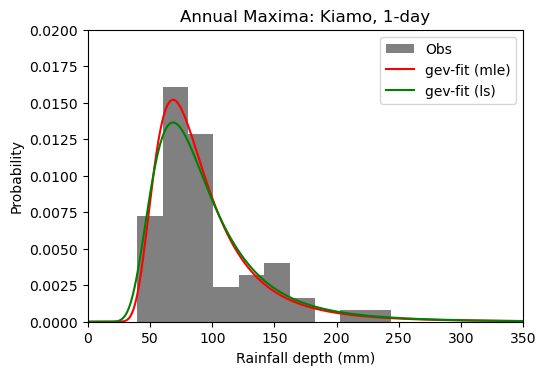

In [5]:
plt.figure(figsize=(6, 4))
bin_num = 10
hist, bins = np.histogram(Kiamo_data, bins=bin_num)
plt.hist(Kiamo_data, bins=bin_num, density=True, color='grey', label='Obs')

x = np.linspace(0, 350, 1000)
MLE_pdf = stats.genextreme.pdf(x, c=MLE_shape, loc=MLE_loc, scale=MLE_scale)
LS_pdf = stats.genextreme.pdf(x, c=LS_shape, loc=LS_loc, scale=LS_scale)
plt.plot(x, MLE_pdf, label='gev-fit (mle)', color='red')
plt.plot(x, LS_pdf, label='gev-fit (ls)', color='green')

plt.xlim(0, 350)
plt.ylim(0, 0.02)
plt.xlabel('Rainfall depth (mm)')
plt.ylabel('Probability')
plt.title('Annual Maxima: Kiamo, 1-day')
plt.legend()

plt.subplots_adjust(left=0.175,bottom=0.15)
plt.savefig("AnnualMax_1D_Kiamo_pdf-comp.png")

### 5. (10%) Another way to evaluate the fitting result is to make q-q plot.  In the q-q plot, you can compare the observed annual maxima (y-axis) with the assocated quantiles dervied from the GEV distributions fitted with the above two methods, respectively. Please export the q-q plot to a PNG file named "_AnnualMax_1D_Kiamo_qqplot.png_".


#### Note for the plot:
* The size of the plot is 6-inch width and 6-inch height.
* The x-axis is for the quantiles and the y-axis for observed annual maxima, respectively. 
* There shall be a 45-degree straight line (grey colour) representing the perfect match.
* The quantiles from the MLE method shall be plotted as red round markers, and the name of markers is 'gev-fit (mle)'.
* The quantiles from the LS method shall be plotted as green round markers, and the name of markers is 'gev-fit (ls)'.
* The range of the values in both x- and y axes is from 0 to 250.
* The text labels of the plot are 'Quantiles (mm)' for x-axis and 'Obs (mm)' for y-axis
* The plot title shall be ('q-q plot: Kiamo, 1-day'). 



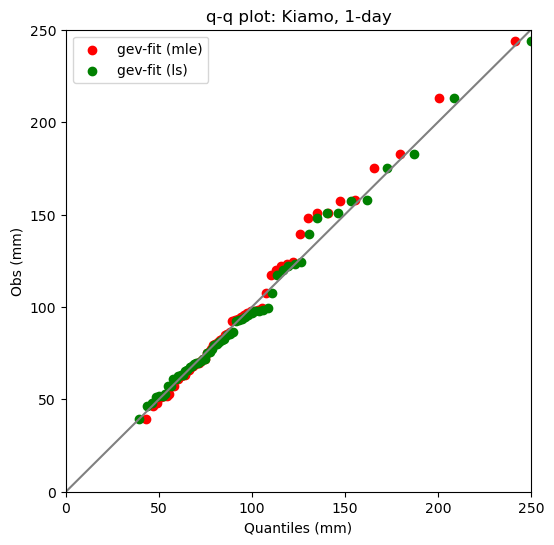

In [6]:
MLE_quantile_value = stats.genextreme.ppf(EP, loc=MLE_loc, c=MLE_shape, scale=MLE_scale)
LS_quantile_value = stats.genextreme.ppf(EP, loc=LS_loc, c=LS_shape, scale=LS_scale)

plt.figure(figsize=(6, 6))
plt.scatter(MLE_quantile_value, sorted_Kiamo_data, label='gev-fit (mle)', color='red')
plt.scatter(LS_quantile_value, sorted_Kiamo_data, label='gev-fit (ls)', color='green')
plt.plot([0, 250], [0, 250], color='grey')

plt.xlim(0, 250)
plt.ylim(0, 250)
plt.xlabel('Quantiles (mm)')
plt.ylabel('Obs (mm)')
plt.title('q-q plot: Kiamo, 1-day')
plt.legend()
plt.savefig("AnnualMax_1D_Kiamo_qqplot.png")

## After the visual inspection and discussion with your colleagues, you decide to choose the fitting result obtained from the _Method 1_ (MLE). Based upon the fitting result, you want to design a drainage network that can cope with 1-day rainfall at 50-year return period.  

## However, you know that there is always _estimation uncertainty_, and it is critical to account for uncertainty in the design process, so you decide to use the 'bootstrapping' method to help estimate the confidence intervals.

### 6. (25%) Please find the 95% (two-sided) confidence level for the 1-day rainfall at 50-year return period using empirical bootstrapping (please set the number of bootstraps as _100_ and random seed to _10_) and print the estimated 1-day rainfall at 50-year reurn period and the confidence intervals.


#### Hint: The relationship between the probability of exceedance ($p$) and the return period ($T_{r}$) is $T_{r} = \frac{1}{1-p}$.

#### Note: the print output shall look like below:

The 50-year return level is: XXXX (3-decimal places) </br>
The bootstrapped confidence interval is: [lower, upper] (3-decimal places)

In [7]:
p = 1-(1/50)
estimated = stats.genextreme.ppf(p, loc=MLE_loc, c=MLE_shape, scale=MLE_scale)
print(f"The 50-year return level is: {estimated:.3f}")

np.random.seed(10)
nBootstraps = 100
nSamples = len(sorted_Kiamo_data)
np_samples = np.array(sorted_Kiamo_data)
re_estimated = np.zeros(nBootstraps)

for b in range(nBootstraps):
    re_b = np.random.choice(np_samples, size = nSamples, replace=True)
    re_shape_b, re_loc_b, re_scale_b = stats.genextreme.fit(re_b)
    re_estimated_b = stats.genextreme.ppf(p, loc=re_loc_b, c=re_shape_b, scale=re_scale_b)
    re_estimated[b] = re_estimated_b

delta_estimated =  re_estimated - estimated
CI_estimated_lower, CI_estimated_upper = estimated - np.percentile(delta_estimated,[97.5,2.5])
print(f"The bootstrapped confidence interval is: [{CI_estimated_lower:.3f}, {CI_estimated_upper:.3f}]")

The 50-year return level is: 228.153
The bootstrapped confidence interval is: [132.346, 290.233]
